In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [2]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load DINOv2 ViT-B/14 with registers
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
dinov2 = dinov2.to(device)
dinov2.eval()

# Freeze everything first
for param in dinov2.parameters():
    param.requires_grad = False

# Unfreeze the last 4 transformer blocks + norm layer so the model
# can adapt its features to the dermoscopic image domain
for block in dinov2.blocks[-4:]:
    for param in block.parameters():
        param.requires_grad = True

for param in dinov2.norm.parameters():
    param.requires_grad = True

trainable = sum(p.numel() for p in dinov2.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in dinov2.parameters())
print(f"DINOv2 embedding dim: {dinov2.embed_dim}")
print(f"Backbone: {trainable:,} / {total_params:,} params unfrozen (last 4 blocks + norm)")

Using device: cuda


Using cache found in C:\Users\Dragos/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\Dragos/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\Dragos/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\Dragos/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DINOv2 embedding dim: 384
Backbone: 7,101,696 / 22,058,112 params unfrozen (last 4 blocks + norm)


In [3]:
# Training transforms WITH augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.85, 1.15)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2),
])

# Val/Test transforms — minimal (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [4]:
# Data path — binary (Benign vs Malignant)
data_dir = r"../DataCleaning/Sorted_Dscope_Binary"

# Load dataset (with val transform just to get class info)
full_dataset = datasets.ImageFolder(root=data_dir, transform=val_transform)

# Class names and counts
class_names = full_dataset.classes
print(f"Classes: {class_names}")
print(f"Total images: {len(full_dataset)}")
for i, cls in enumerate(class_names):
    count = sum(1 for _, label in full_dataset.samples if label == i)
    print(f"  {cls}: {count}")

Classes: ['Benign', 'Malignant']
Total images: 965
  Benign: 454
  Malignant: 511


In [ ]:
num_classes = len(full_dataset.classes)

class_counts = {}
for i in range(num_classes):
    class_counts[i] = sum(1 for _, label in full_dataset.samples if label == i)

total_samples = sum(class_counts.values())

class_weights = []
for i in range(num_classes):
    weight = total_samples / (num_classes * class_counts[i])
    class_weights.append(weight)

class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print("Class weights calculated:")
for i, weight in enumerate(class_weights):
    print(f"  {class_names[i]} (Class {i}): {weight:.4f} (count: {class_counts[i]})")

Class weights calculated:
  Benign (Class 0): 1.0628 (count: 454)
  Malignant (Class 1): 0.9442 (count: 511)


In [ ]:
total = len(full_dataset)
train_size = int(0.70 * total)
val_size = int(0.15 * total)
test_size = total - train_size - val_size

In [ ]:
train_subset, val_subset, test_subset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

In [ ]:
# create a separate augmented dataset for training
train_aug_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

train_dataset = Subset(train_aug_dataset, train_subset.indices)
val_dataset = Subset(full_dataset, val_subset.indices)      # val uses val_transform (no aug)
test_dataset = Subset(full_dataset, test_subset.indices)     # test uses val_transform (no aug)

print(f"Train: {len(train_dataset)} (with augmentation) | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Train: 675 (with augmentation) | Val: 144 | Test: 146


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [ ]:
# classification head on top of DINOv2 backbone (last 4 blocks unfrozen)
class DinoV2Classifier(nn.Module):
    def __init__(self, backbone, num_classes, embed_dim=768):
        super().__init__()
        self.backbone = backbone
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3), 
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1), 
            nn.Linear(128, num_classes) 
        )
    
    def forward(self, x):
        features = self.backbone(x)  # [B, embed_dim]
        return self.classifier(features)

num_classes = len(class_names)
model = DinoV2Classifier(dinov2, num_classes=num_classes, embed_dim=dinov2.embed_dim)
model = model.to(device)

total_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_trainable:,}")

Total trainable parameters: 7,366,018


In [ ]:
# focal loss from https://github.com/itakurah/focal-loss-pytorch/blob/main/focal_loss.py 
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)  # probability of correct class
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        return focal_loss.sum()

In [ ]:
# use the class weights for alpha from focal loss
criterion = FocalLoss(alpha=class_weights_tensor, gamma=2.0)

In [ ]:
optimizer = optim.AdamW([
    {"params": [p for p in dinov2.blocks[-4:].parameters() if p.requires_grad], "lr": 1e-5},  # different lr for each block to minimize overfitting
    {"params": [p for p in dinov2.norm.parameters() if p.requires_grad], "lr": 1e-5}, 
    {"params": model.classifier.parameters(), "lr": 5e-4},
], weight_decay=1e-2)

In [ ]:
num_epochs = 40
warmup_epochs = 5

warmup_scheduler = LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs)
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs - warmup_epochs, eta_min=1e-7)
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[warmup_epochs])

train_losses, val_losses = [], []
train_accs, val_accs = [], []

# early stopping
best_val_loss = float('inf')
patience = 8
patience_counter = 0
best_model_state = None

In [ ]:
for epoch in range(num_epochs):
    # training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # validation
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    val_loss = running_loss / total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
    else:
        patience_counter += 1
    
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | "
          f"LR: {current_lr:.2e}"
          + (f" best" if patience_counter == 0 else f" (patience {patience_counter}/{patience})"))
    
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# get best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nRestored best model (val loss: {best_val_loss:.4f})")

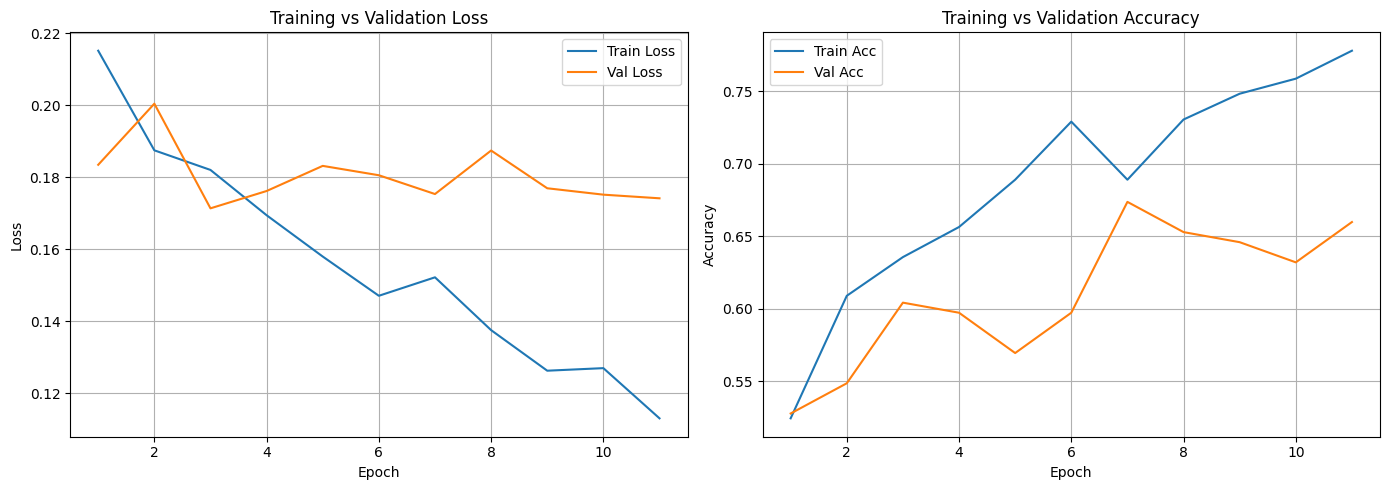

In [ ]:
# plot training vs validation loss and accuracy
actual_epochs = len(train_losses)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(1, actual_epochs+1), train_losses, label='Train Loss')
ax1.plot(range(1, actual_epochs+1), val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training vs Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(range(1, actual_epochs+1), train_accs, label='Train Acc')
ax2.plot(range(1, actual_epochs+1), val_accs, label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training vs Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# eval time
model.eval()
all_probs, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # P(Malignant)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# compare 
print("=" * 60)
print("DEFAULT THRESHOLD (0.50)")
print("=" * 60)
default_preds = (all_probs >= 0.50).astype(int)
print(f"Test Accuracy: {(default_preds == all_labels).mean():.4f}\n")
print(classification_report(all_labels, default_preds, target_names=class_names))

DEFAULT THRESHOLD (0.50)
Test Accuracy: 0.5959

              precision    recall  f1-score   support

      Benign       0.58      0.62      0.60        72
   Malignant       0.61      0.57      0.59        74

    accuracy                           0.60       146
   macro avg       0.60      0.60      0.60       146
weighted avg       0.60      0.60      0.60       146


OPTIMIZED THRESHOLD (0.35)
Test Accuracy: 0.5616

              precision    recall  f1-score   support

      Benign       0.67      0.22      0.33        72
   Malignant       0.54      0.89      0.67        74

    accuracy                           0.56       146
   macro avg       0.60      0.56      0.50       146
weighted avg       0.60      0.56      0.51       146



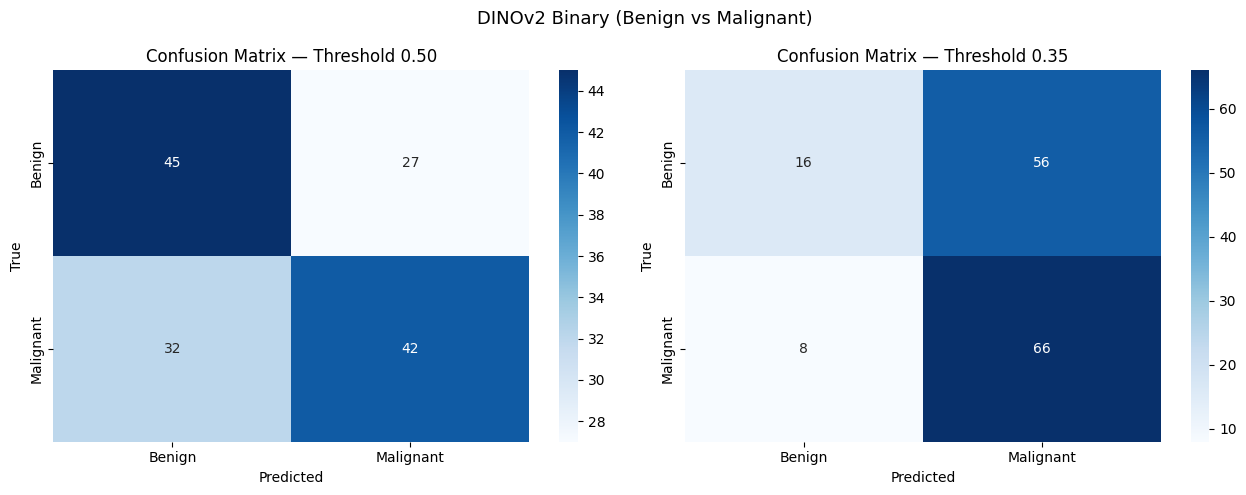

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

cm_default = confusion_matrix(all_labels, default_preds)
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')
ax1.set_title('Confusion Matrix — Threshold 0.50')

plt.suptitle('DINOv2 Binary (Benign vs Malignant)', fontsize=13)
plt.tight_layout()
plt.show()